# Visualizing the search in real-time

## Introduction

In this Jupyter notebook, we'll demonstrate how to use the Brightest Path package to visualize where the algorithm is searching in real-time using threading.

## Installation

Before we get started, let's install the Brightest Path library. You can install it using pip:



```sh
pip install brightest-path-lib
```

## Loading an Image

We'll start by loading an image to find the brightest path on. For this demo, we'll use the `cells3d()` function from the `skimage.data` module to generate a synthetic image of cells. Please note, the first time you import skimage data, it can take some time to download the data.

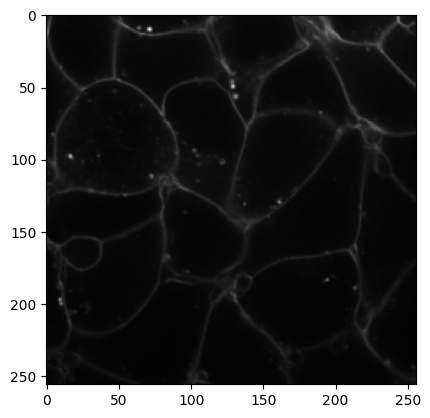

In [1]:
from skimage import data
import matplotlib.pyplot as plt

image = data.cells3d()[30, 0]
plt.imshow(image, cmap='gray')

## Defining the start and end points

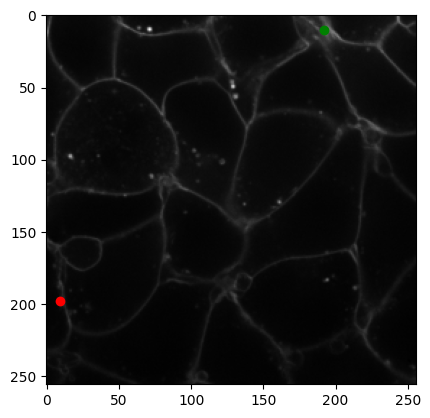

In [2]:
import numpy as np

start_point = np.array([10,192]) # [y, x]
end_point = np.array([198,9])

# let's show the start and end points
plt.imshow(image, cmap='gray')
plt.plot(start_point[1], start_point[0], 'og')
plt.plot(end_point[1], end_point[0], 'or')

## We want to run the search algorithms in separate threads

Let's do it for A* Search first. We'll start with importing the following libraries:

In [3]:
from queue import Empty, Queue
from threading import Thread
from typing import List

from brightest_path_lib.algorithm import AStarSearch

To show the visualization in real-time, we need the list of points that are currently in the open set. To do that, we will pass a `Queue` to the AStarSearch algorithm, which in turn will keep filling it with the points in the current search space.

We will also define methods to help us cancel the search, and run the A* search using threads.

In [4]:
class AStarThread(Thread):
    def __init__(self,
        image : np.ndarray,
        start_point : np.ndarray,
        goal_point : np.ndarray,
        queue = None):
        super().__init__(daemon=True)
        self.queue = queue
        self.search_algorithm = AStarSearch(image, start_point=start_point, goal_point=goal_point, open_nodes=queue)
    
    def cancel(self):
        self.search_algorithm.is_canceled = True
    
    def run(self):
        self.search_algorithm.search()

Let's instantiate this thread class now and start the visualizations:

Found goal!


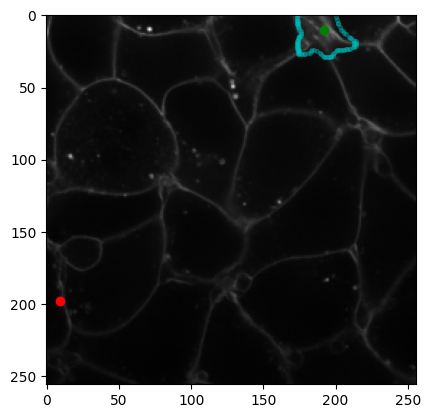

In [9]:
from IPython.display import clear_output

# create a queue to have the open nodes
queue = Queue()

search_thread = AStarThread(image, start_point, end_point, queue)
search_thread.start()  # start the thread, internally Python calls tt.run()

_updateInterval = 100  # wait for this number of results and update plot
plotItems = []

while search_thread.is_alive() or not queue.empty(): # polling the queue
    # comment this out to see the full animation
    if search_thread.search_algorithm.found_path:
        break

    try:
        item = queue.get(False)
        # update a matplotlib/pyqtgraph/napari interface
        plotItems.append(item)
        if len(plotItems) > _updateInterval:
            yPlot = [point[0] for point in plotItems]
            xPlot = [point[1] for point in plotItems]
            clear_output(wait=True)
            plt.imshow(image, cmap='gray')
            plt.plot(start_point[1], start_point[0], 'og')
            plt.plot(end_point[1], end_point[0], 'or')
            plt.scatter(xPlot, yPlot, c='c', s=8, alpha=0.3)
            plt.pause(0.0001)
            plotItems = []

    except Empty:
        # Handle empty queue here
        pass

**Note:** The visualization code does not display all the points currently being examined because it stops the moment it find the brightest path. 

If you want to show the whole visualization, comment the following lines in the above while loop:

```python
if search_thread.search_algorithm.found_path:
    break
```

Now we will plot the final brightest path from our search thread.

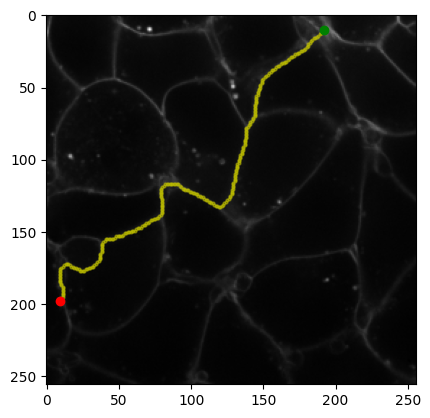

In [10]:
if search_thread.search_algorithm.found_path:
    # once the path is found, clear the visualization being shown
    plt.clf()

    # show the image, start and end points
    plt.imshow(image, cmap='gray')
    plt.plot(start_point[1], start_point[0], 'og')
    plt.plot(end_point[1], end_point[0], 'or')

    # show the brightest path obtained from the search
    yPlot = [point[0] for point in search_thread.search_algorithm.result]
    xPlot = [point[1] for point in search_thread.search_algorithm.result]
    plt.scatter(xPlot, yPlot, c='y', s=4, alpha=0.5)
    plt.pause(0.001)
    

# keep the plot up
plt.show()